In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

# Wczytanie danych

In [2]:
df = pd.read_parquet('data/states_prepared_mod.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


## Podział

In [3]:
df.columns

Index(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       ...
       'de_ancient', 'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke',
       'de_overpass', 'de_vertigo', 'bombsite_A', 'bombsite_B',
       'bombsite_not_planted'],
      dtype='object', length=104)

In [4]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')
df_train, df_test = df.loc[~filtr], df.loc[filtr]
df_train.shape, df_test.shape

((2886886, 104), (299351, 104))

In [5]:
match_map = df_train.groupby(['filename', 'mapName']).indices
len(match_map.keys())

299

In [6]:
df_train

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
299351,IEM-Dallas-2022-astralis-vs-vitality-vertigo_7...,de_vertigo,Full Eco,Full Eco,CT,33,1,0.226562,5,4050,...,0,0,0,0,0,0,1,0,0,1
299352,IEM-Dallas-2022-astralis-vs-vitality-vertigo_7...,de_vertigo,Full Eco,Full Eco,CT,33,1,0.476562,5,4050,...,0,0,0,0,0,0,1,0,0,1
299353,IEM-Dallas-2022-astralis-vs-vitality-vertigo_7...,de_vertigo,Full Eco,Full Eco,CT,33,1,0.726562,5,4050,...,0,0,0,0,0,0,1,0,0,1
299354,IEM-Dallas-2022-astralis-vs-vitality-vertigo_7...,de_vertigo,Full Eco,Full Eco,CT,33,1,0.976562,5,4050,...,0,0,0,0,0,0,1,0,0,1
299355,IEM-Dallas-2022-astralis-vs-vitality-vertigo_7...,de_vertigo,Full Eco,Full Eco,CT,33,1,1.226562,5,4050,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


In [7]:
maps = len(match_map.keys())
np.random.seed(14)
fold_indexes_1 = np.random.choice(maps, size=round(0.33*maps), replace=False)
fold_indexes_2 = np.random.choice(np.delete(np.arange(maps), fold_indexes_1), size=round(0.33*maps), replace=False)
fold_indexes_3 = np.delete(np.arange(maps), np.concatenate((fold_indexes_1, fold_indexes_2)))
fold_1 = []
fold_2 = []
fold_3 = []
for i, key in enumerate(match_map):
    if i in fold_indexes_1:
        fold_1.append(match_map[key])
    elif i in fold_indexes_2:
        fold_2.append(match_map[key])
    elif i in fold_indexes_3:
        fold_3.append(match_map[key])
    else:
        print(f"{key=}")
fold_1 = np.concatenate(fold_1)
fold_2 = np.concatenate(fold_2)
fold_3 = np.concatenate(fold_3)
fold_1.shape, fold_2.shape, fold_3.shape

((937965,), (956136,), (992785,))

In [8]:
np.intersect1d(fold_1, fold_2), np.intersect1d(fold_1, fold_3), np.intersect1d(fold_2, fold_3)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [9]:
df_fold_1 = df_train.iloc[fold_1]
df_fold_1['winningSide'].value_counts(normalize=True)

CT    0.517855
T     0.482145
Name: winningSide, dtype: float64

In [10]:
df_fold_2 = df_train.iloc[fold_2]
df_fold_2['winningSide'].value_counts(normalize=True)

CT    0.528917
T     0.471083
Name: winningSide, dtype: float64

In [11]:
df_fold_3 = df_train.iloc[fold_3]
df_fold_3['winningSide'].value_counts(normalize=True)

CT    0.52462
T     0.47538
Name: winningSide, dtype: float64

In [12]:
fold_1

array([ 537266,  537267,  537268, ..., 2868524, 2868525, 2868526],
      dtype=int64)

In [13]:
df["fold"] = np.zeros(df.shape[0])
df.loc[df_train.index[fold_1], "fold"] = 1
df.loc[df_train.index[fold_2], "fold"] = 2
df.loc[df_train.index[fold_3], "fold"] = 3

In [14]:
np.min(df_test.index), np.max(df_test.index)

(0, 299350)

In [15]:
np.min(df_train.index), np.max(df_train.index)

(299351, 3186236)

In [16]:
df.loc[filtr, "fold"].value_counts(normalize=True)

0.0    1.0
Name: fold, dtype: float64

In [17]:
df.loc[~filtr, "fold"].value_counts(normalize=True)

3.0    0.343895
2.0    0.331200
1.0    0.324905
Name: fold, dtype: float64

In [18]:
df.fold.value_counts(normalize=True)

3.0    0.311585
2.0    0.300083
1.0    0.294380
0.0    0.093951
Name: fold, dtype: float64

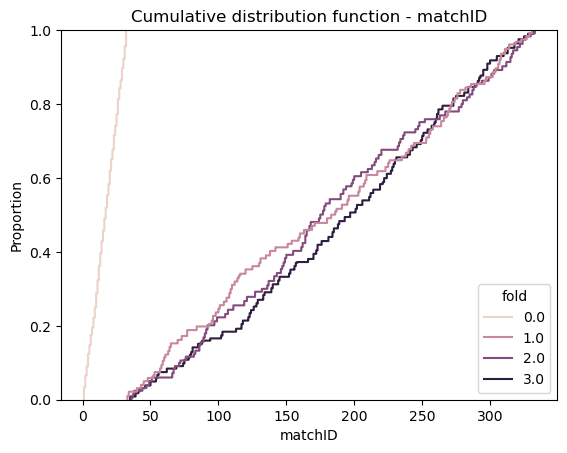

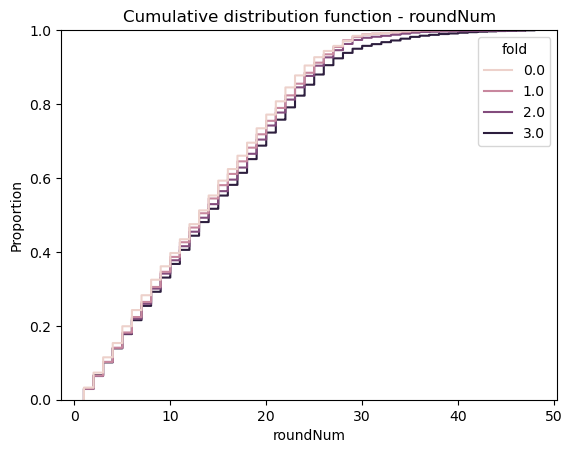

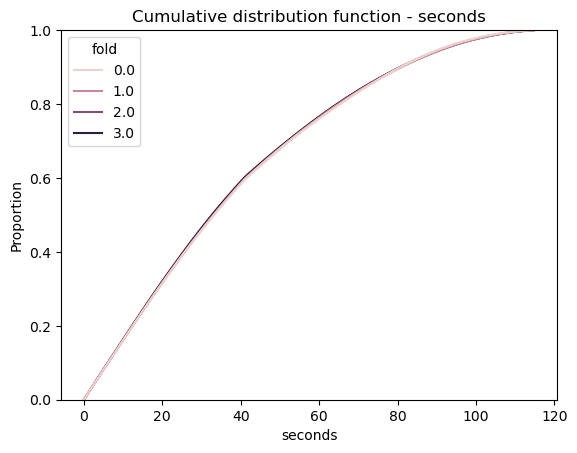

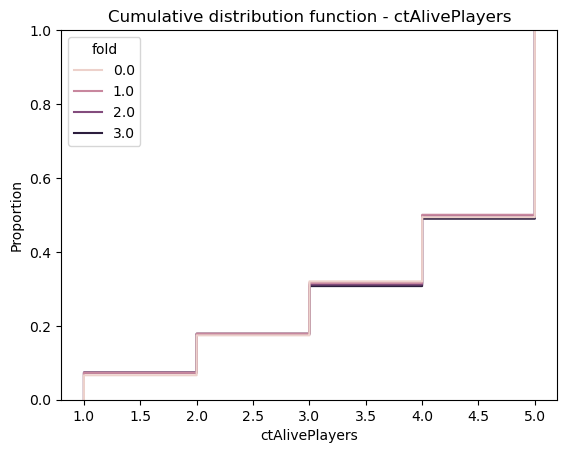

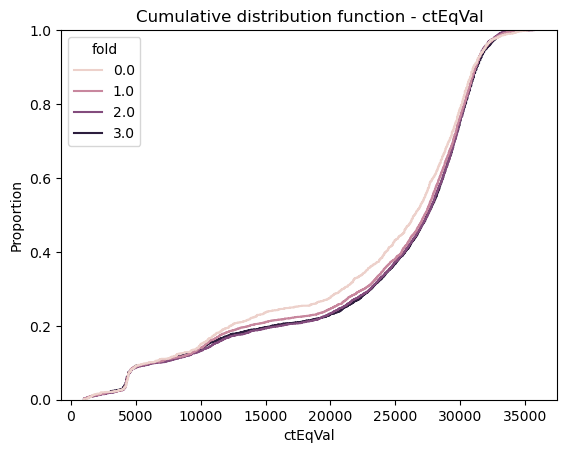

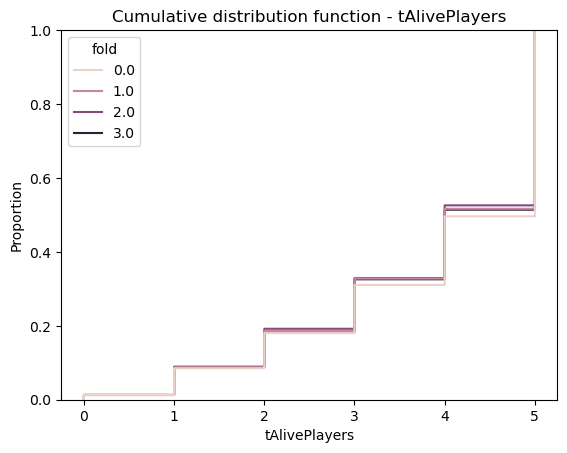

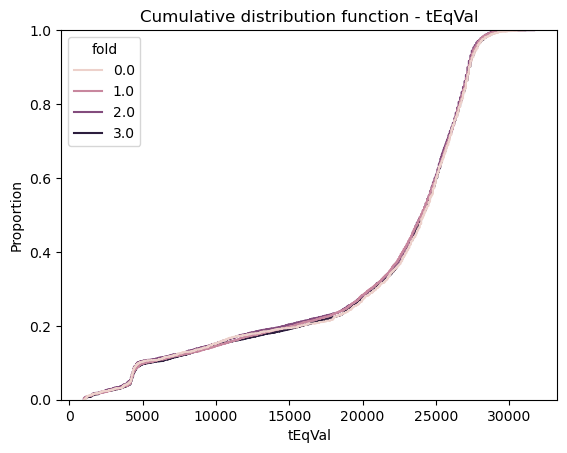

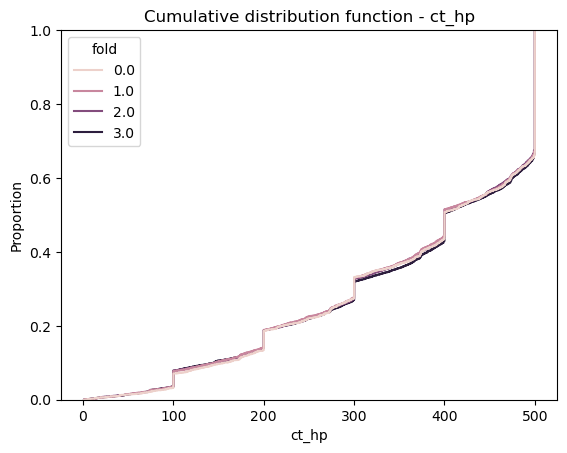

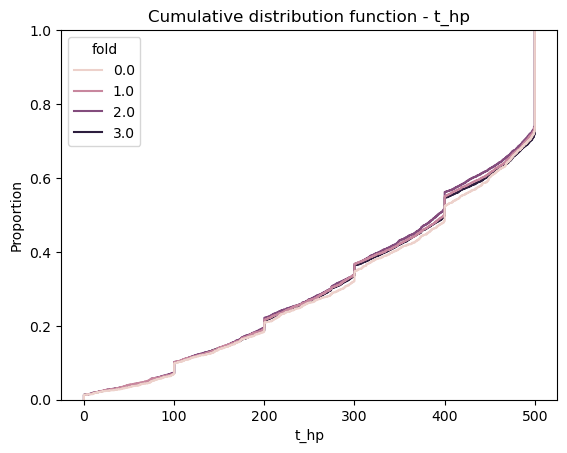

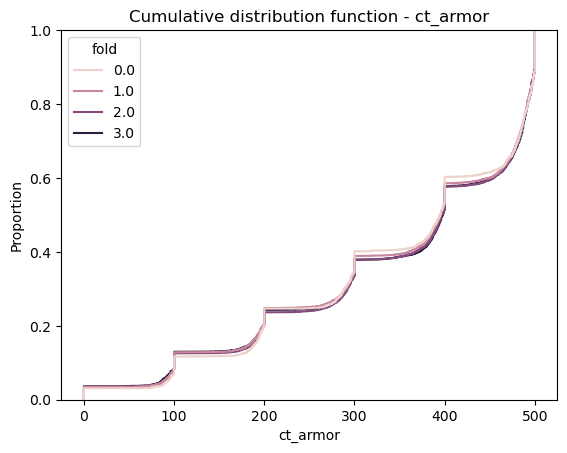

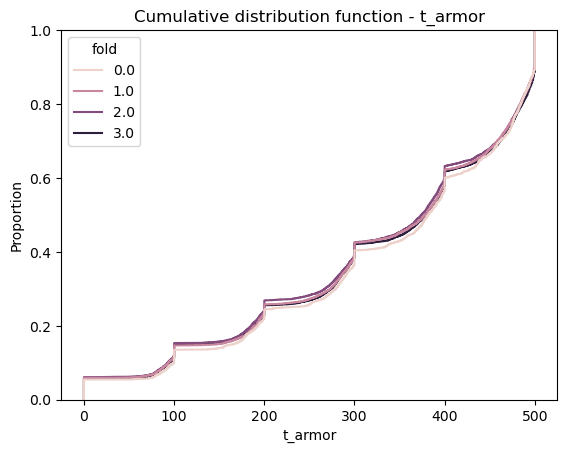

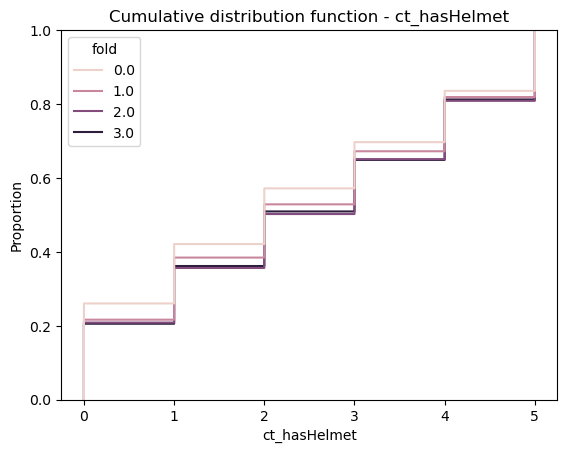

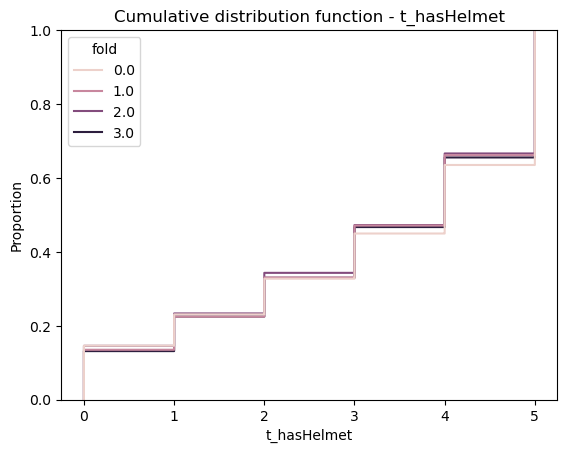

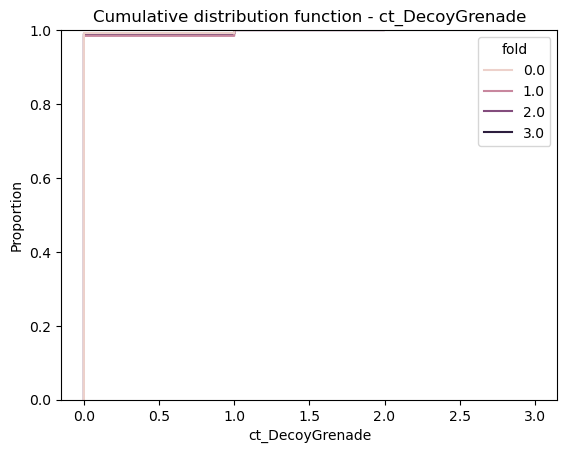

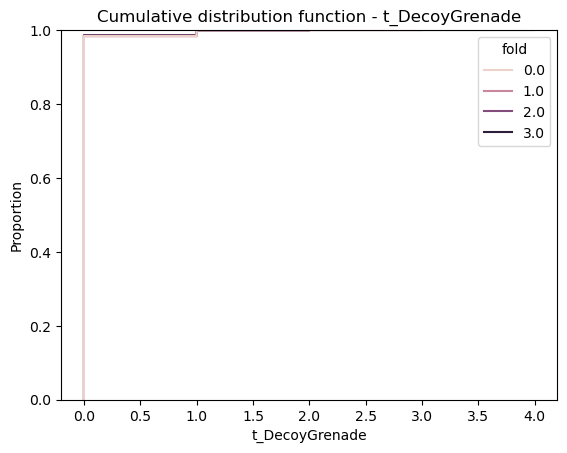

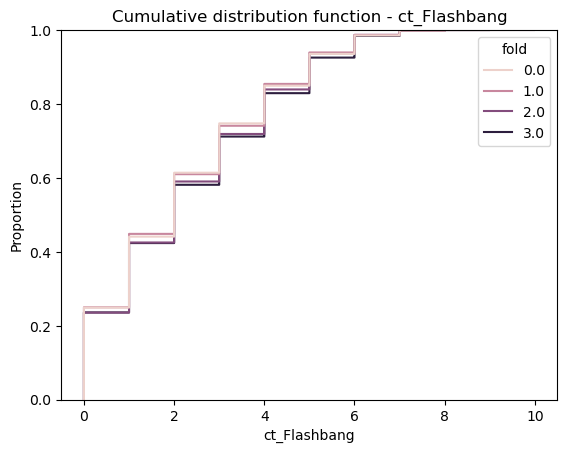

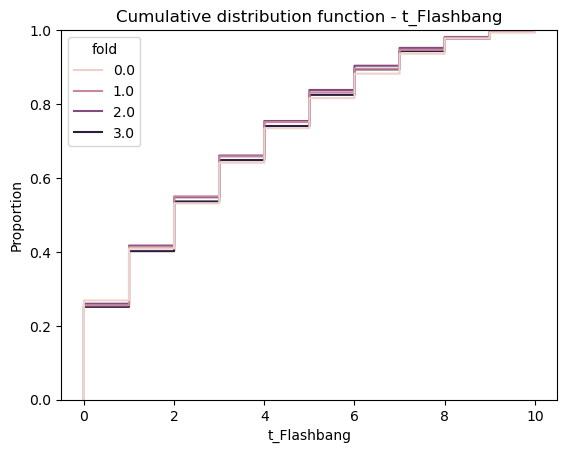

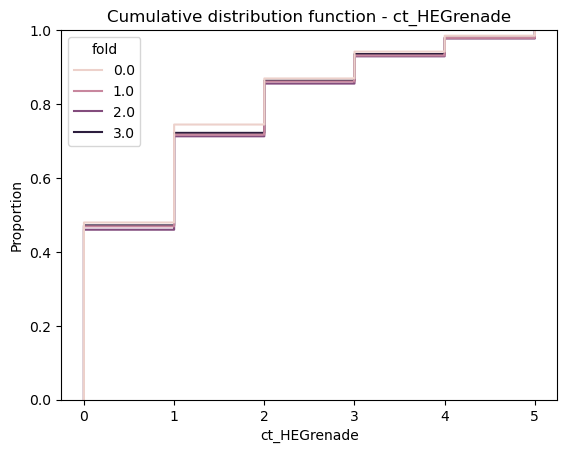

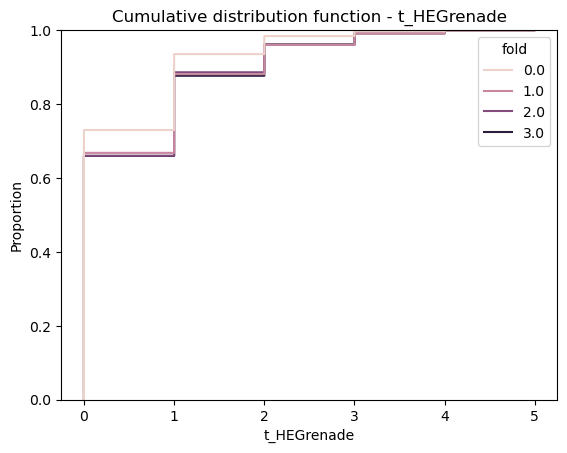

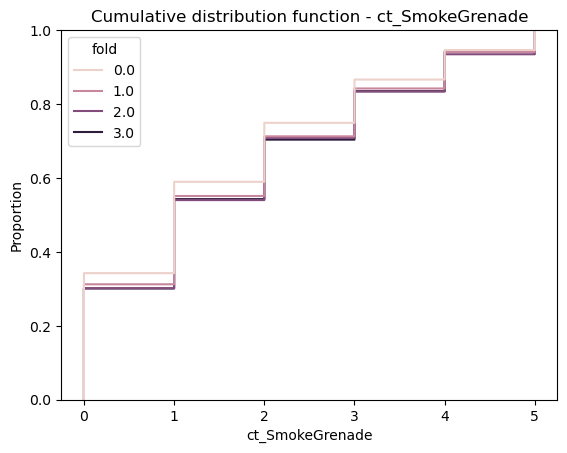

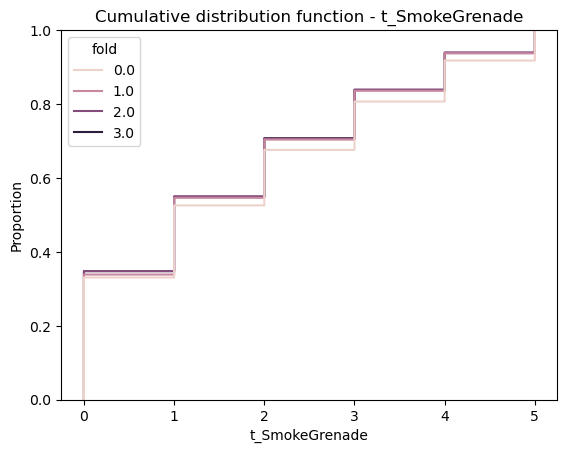

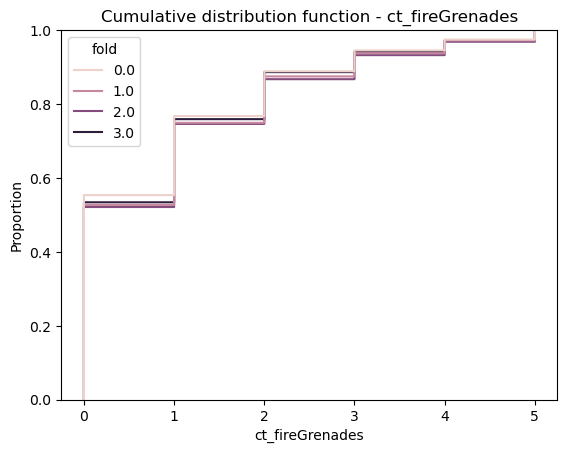

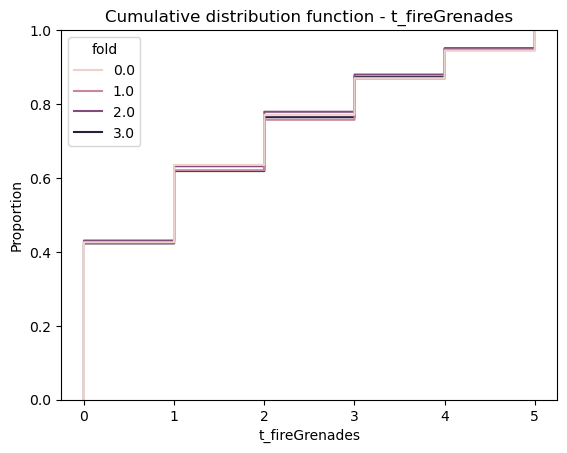

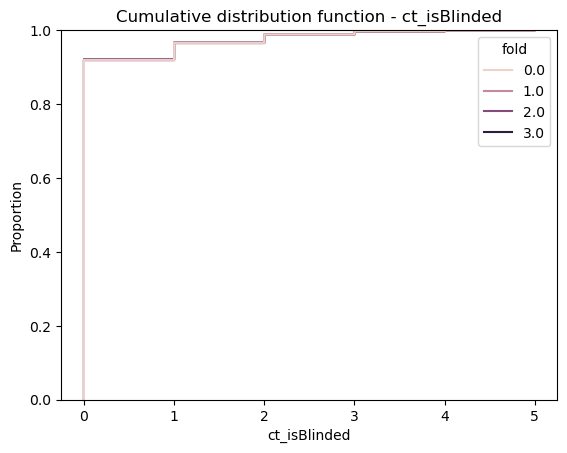

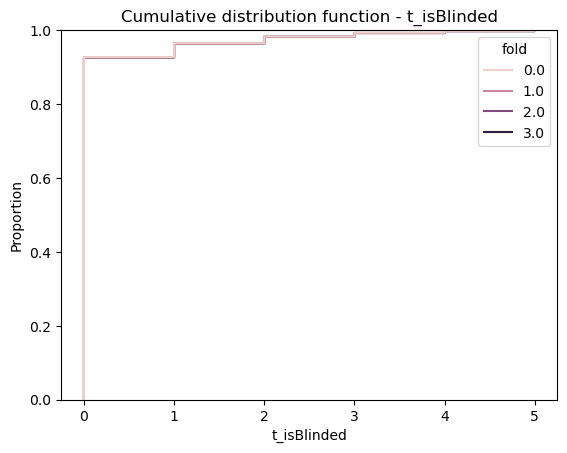

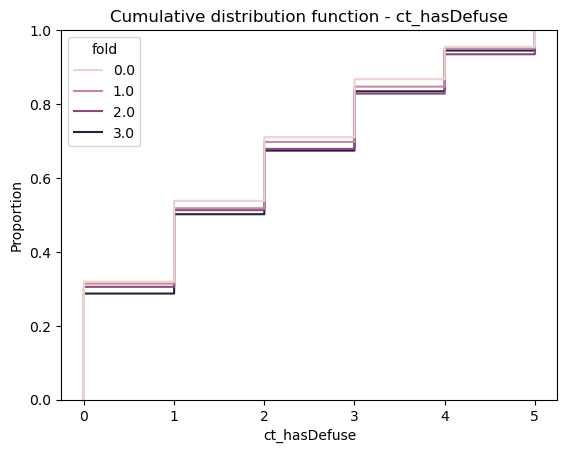

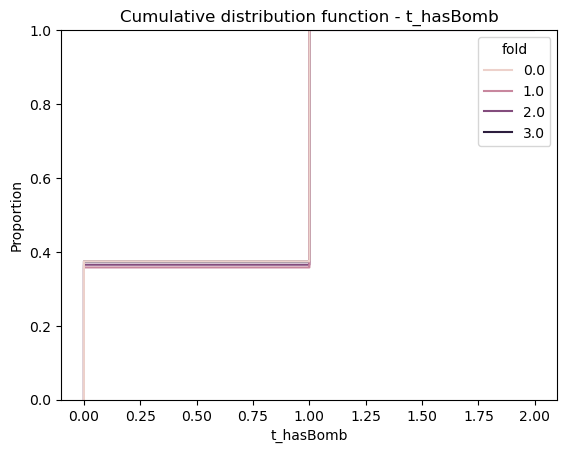

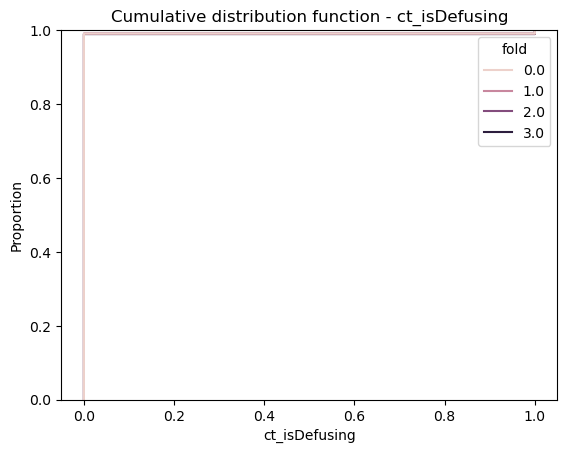

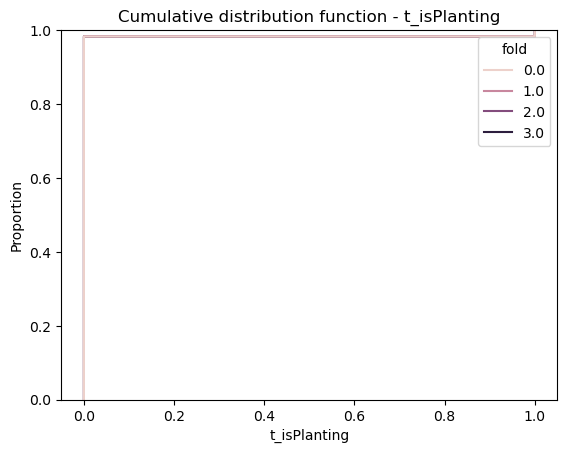

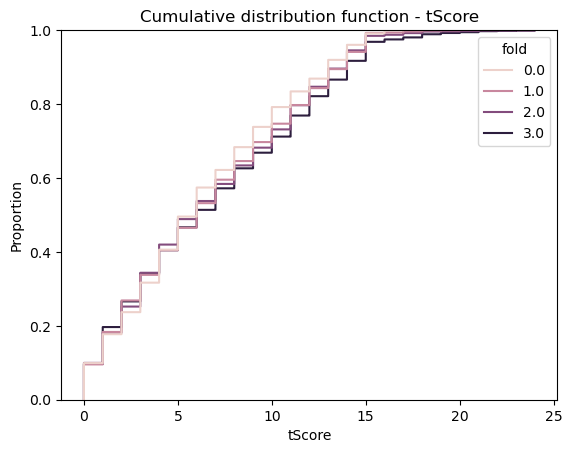

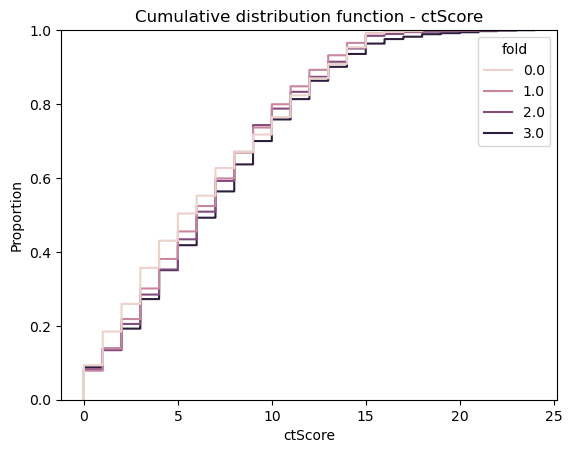

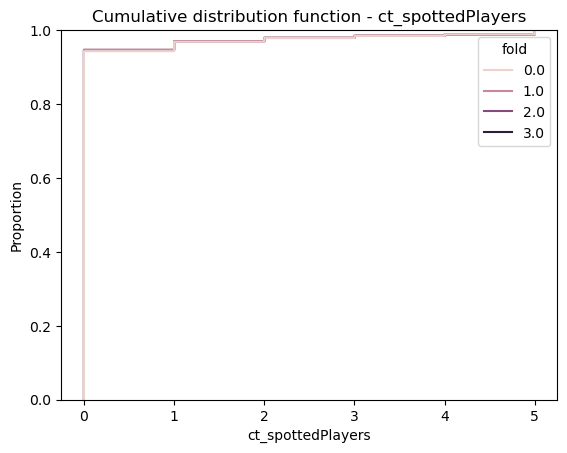

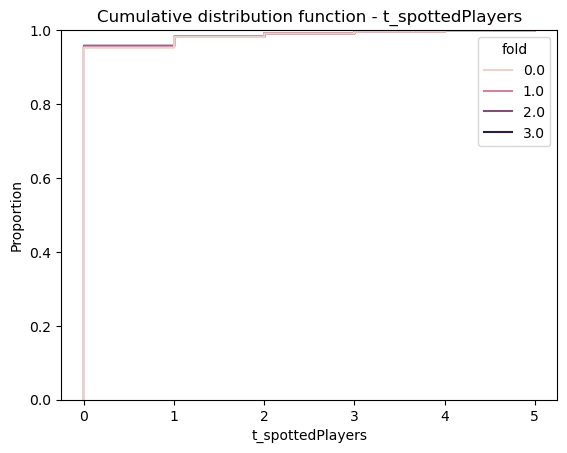

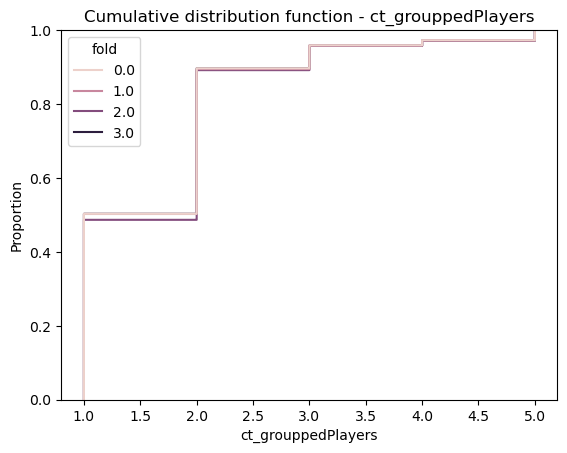

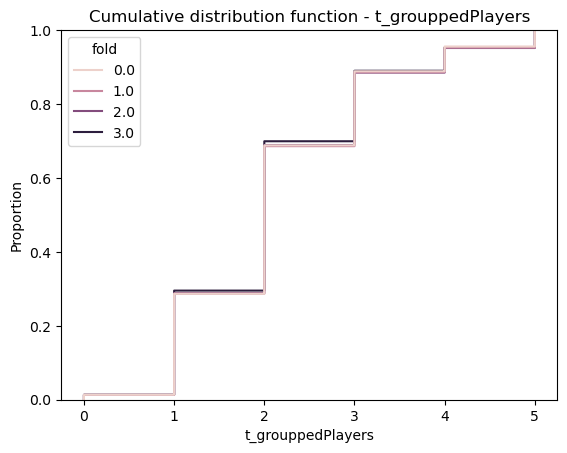

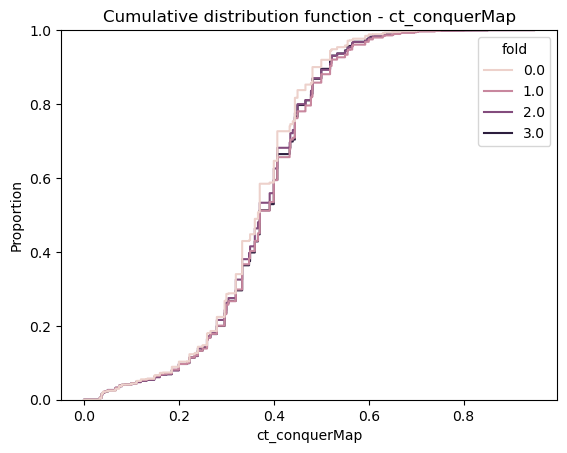

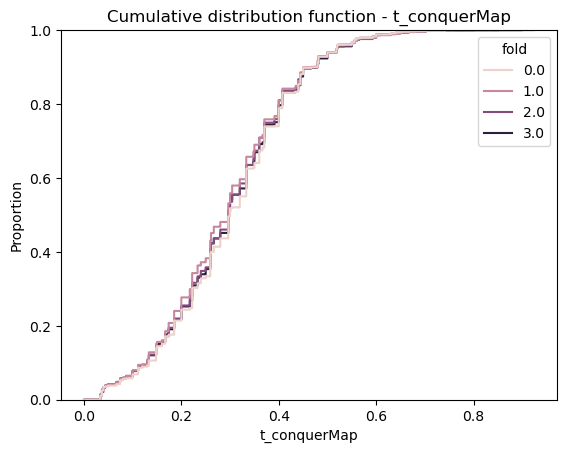

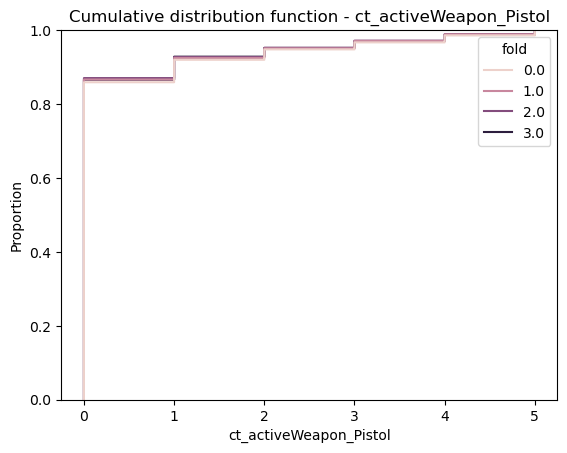

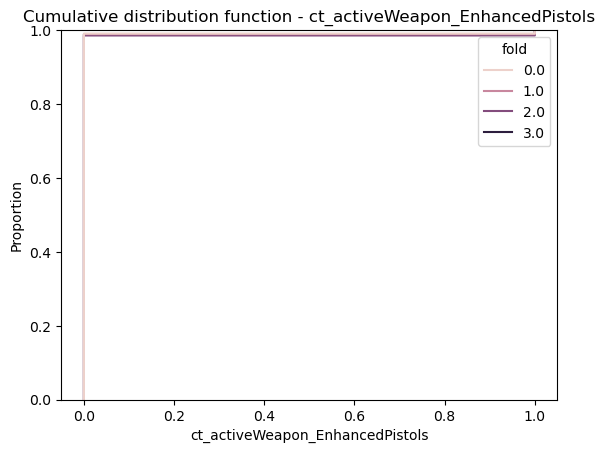

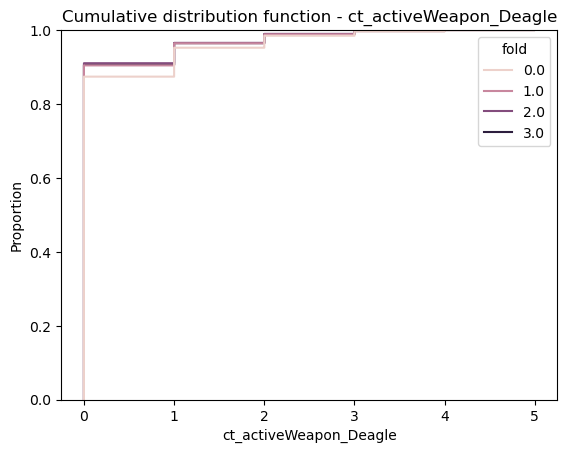

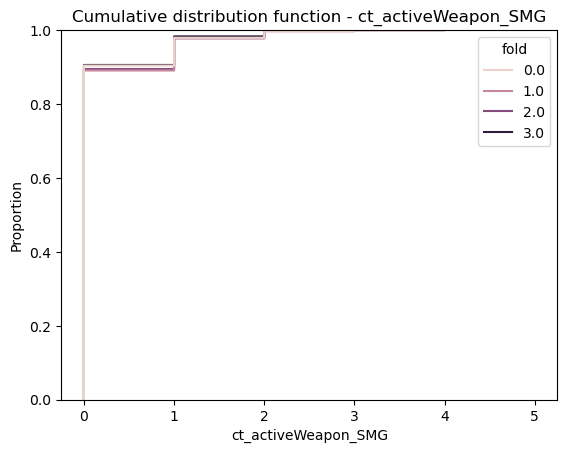

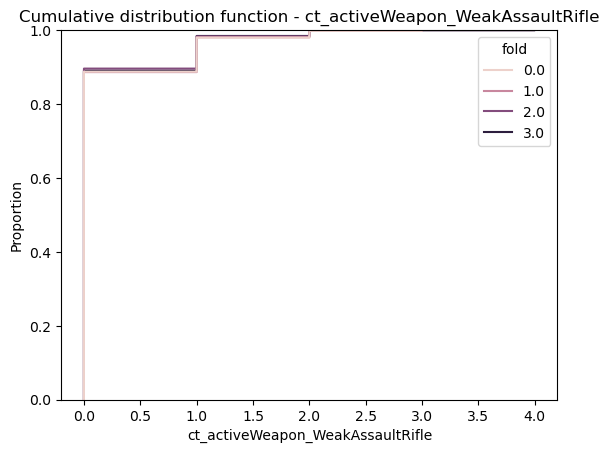

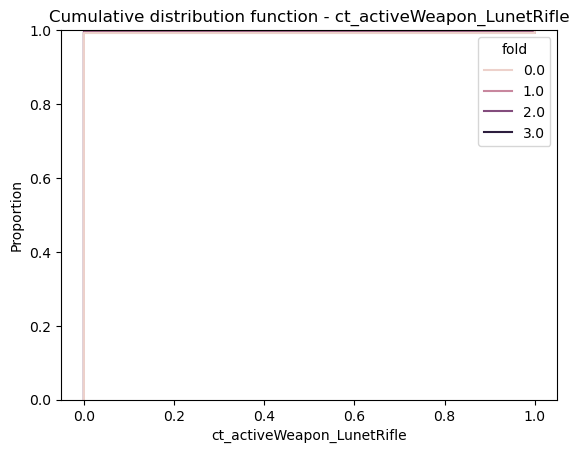

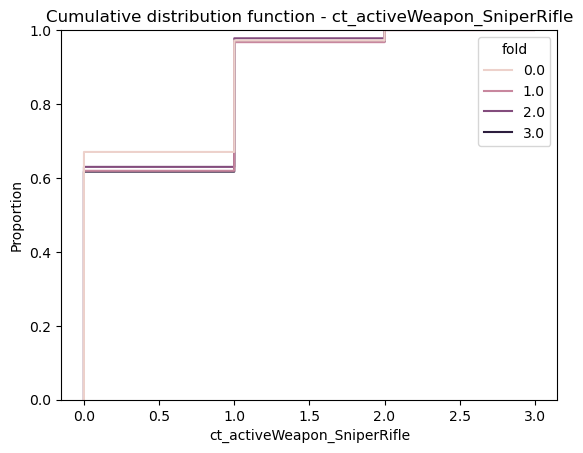

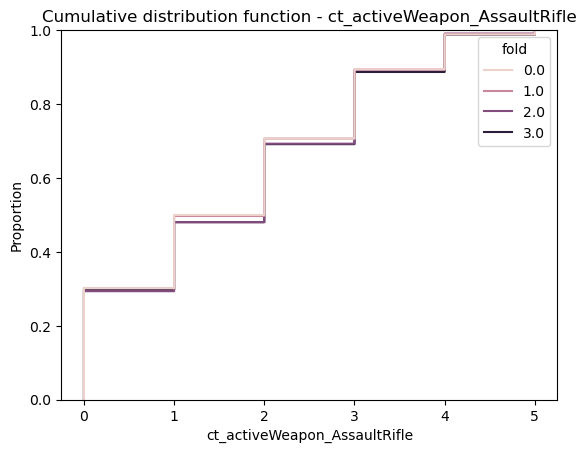

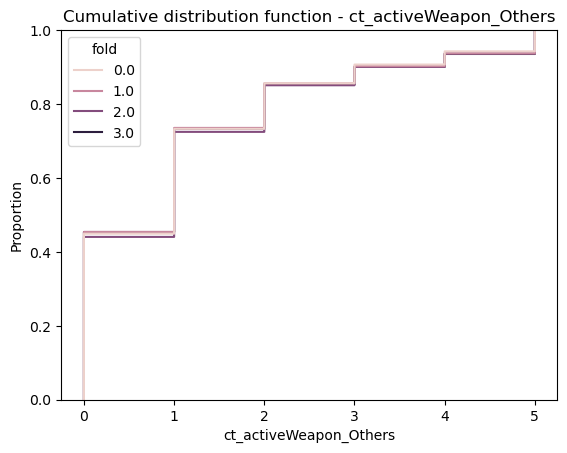

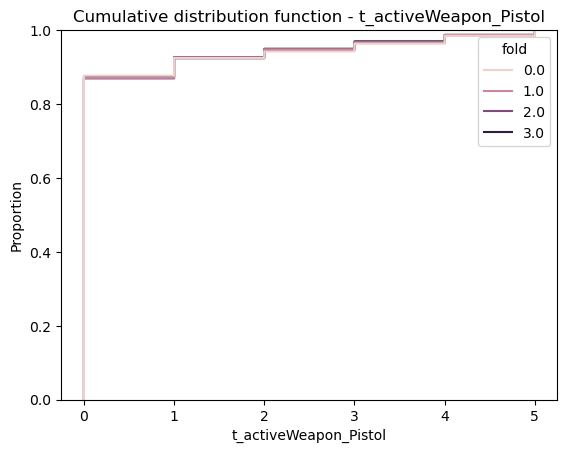

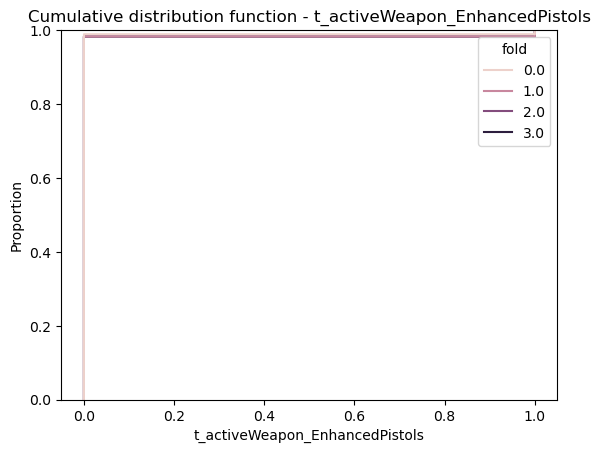

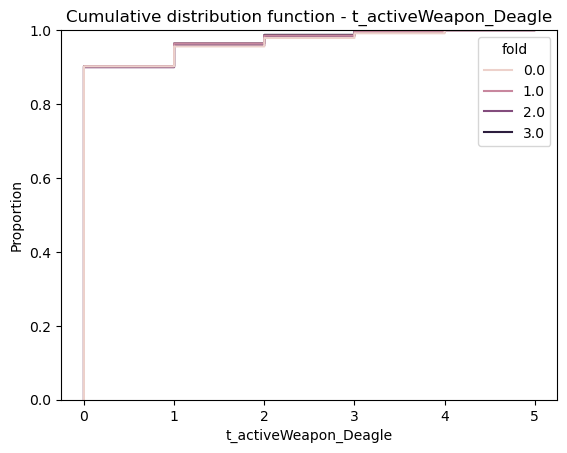

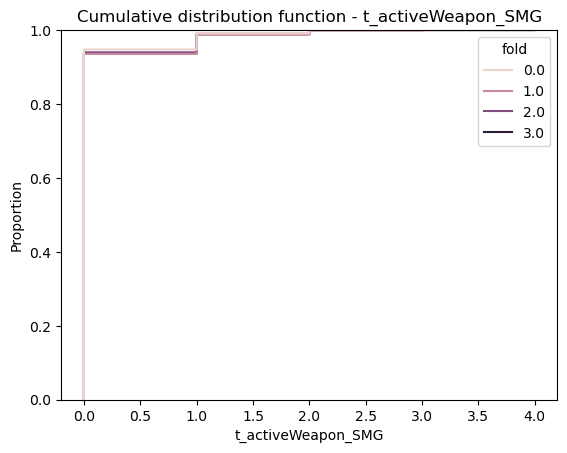

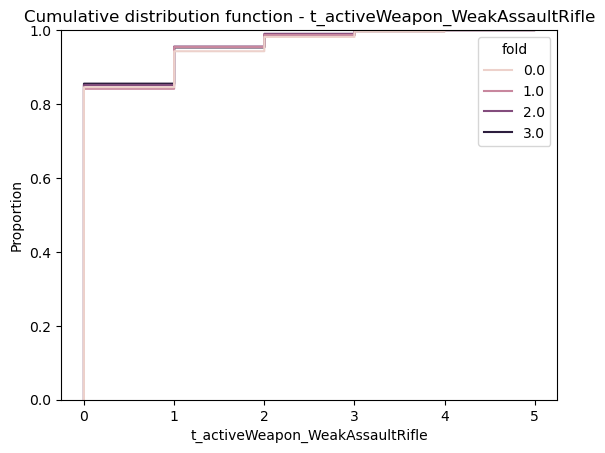

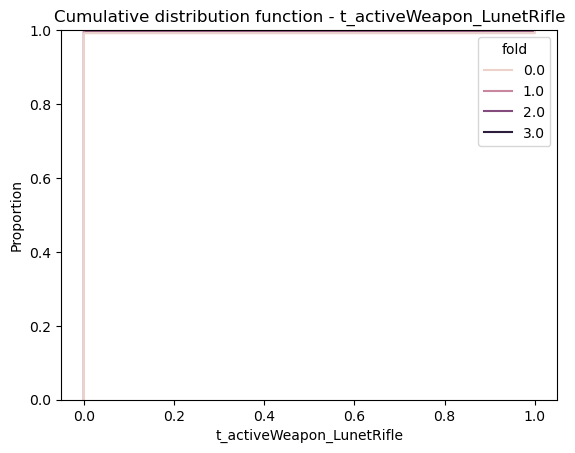

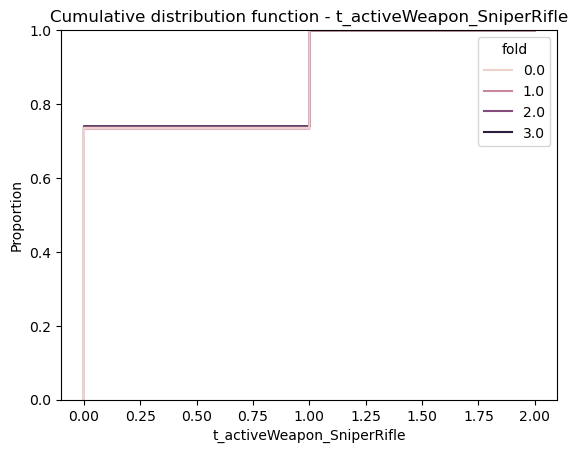

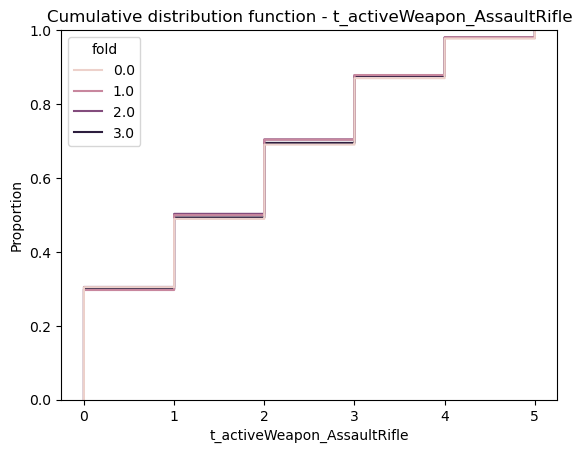

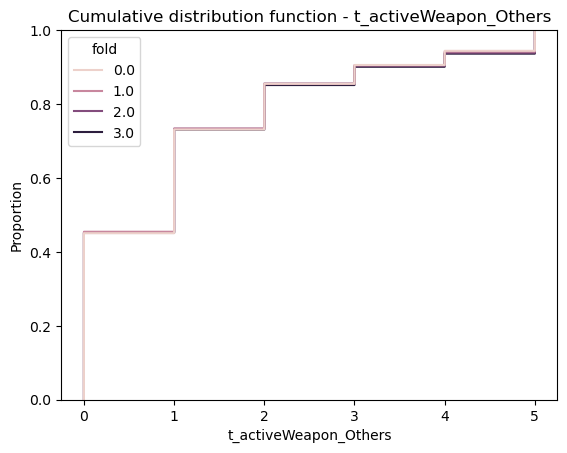

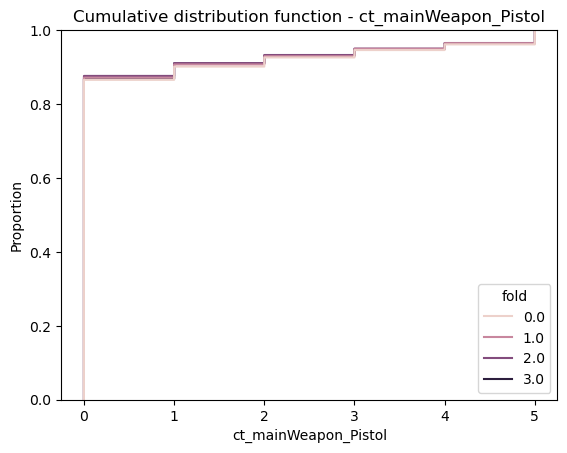

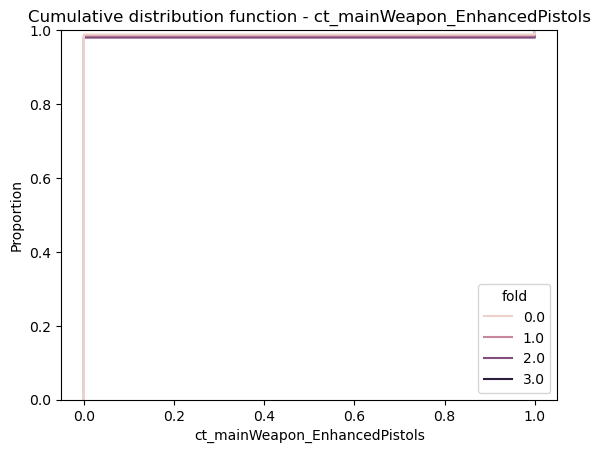

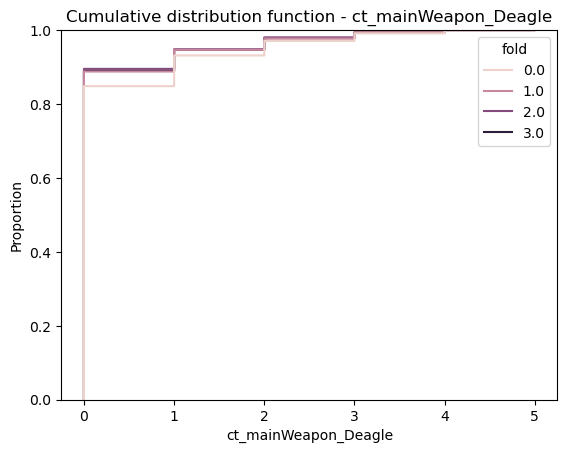

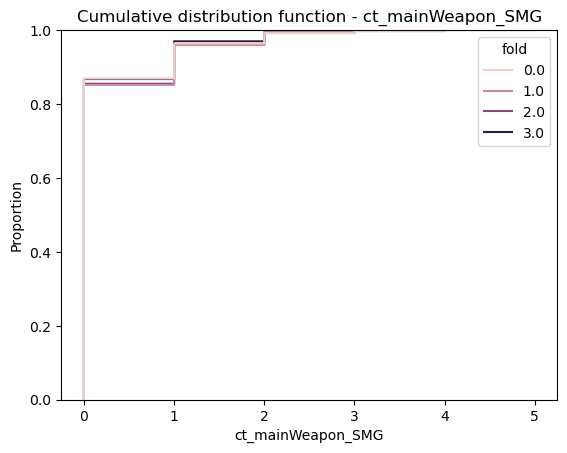

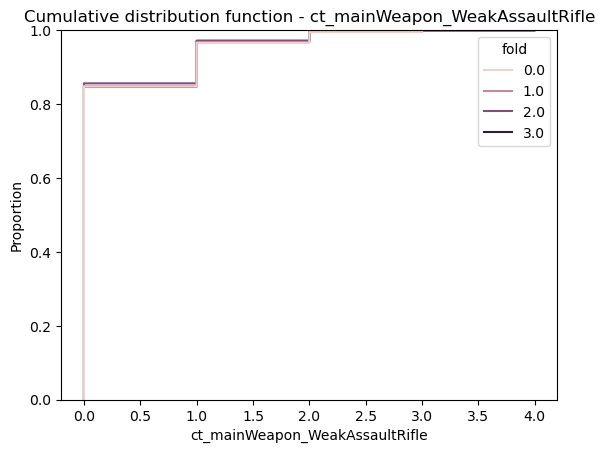

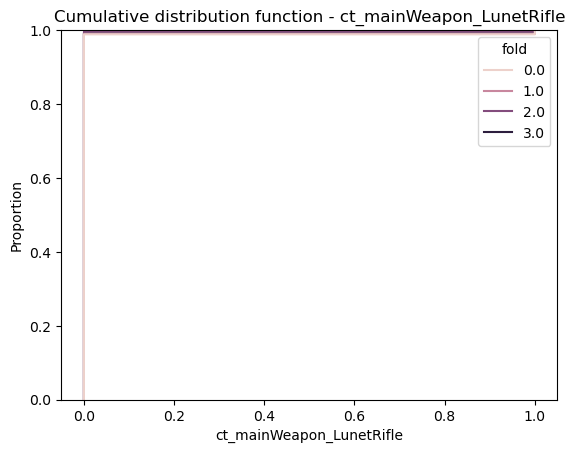

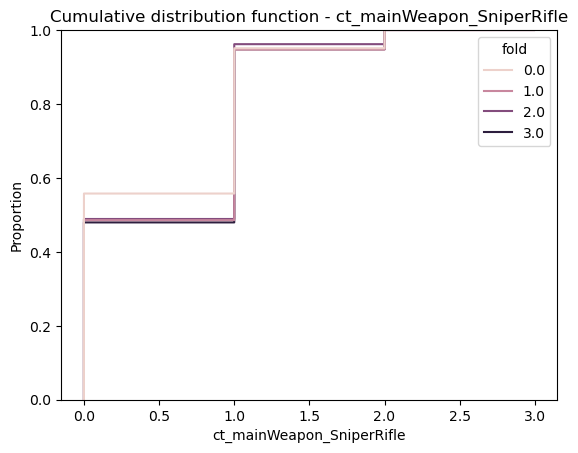

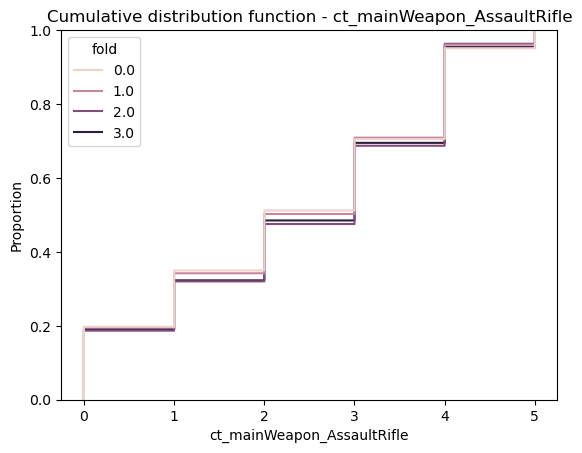

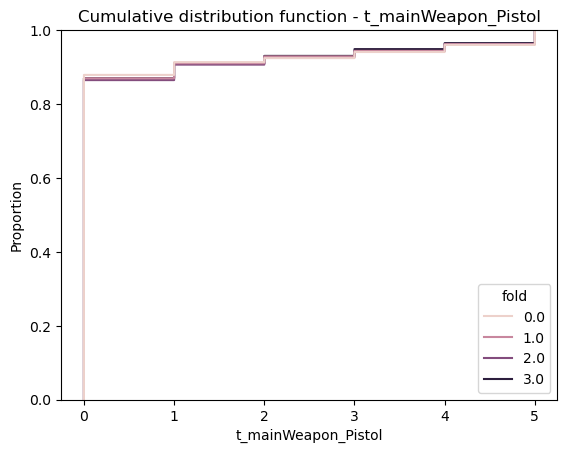

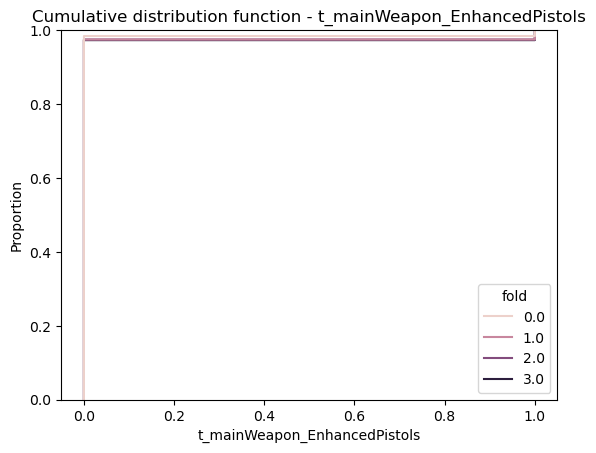

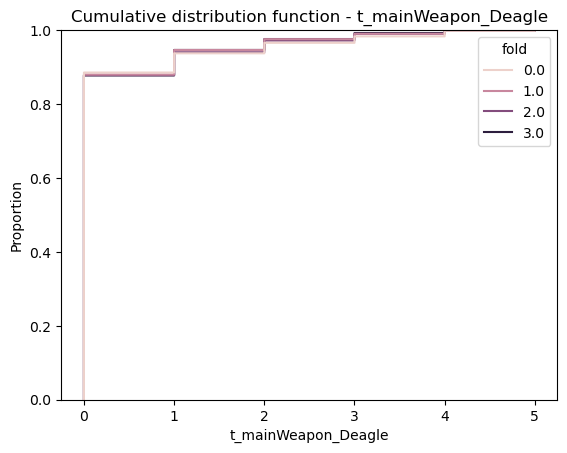

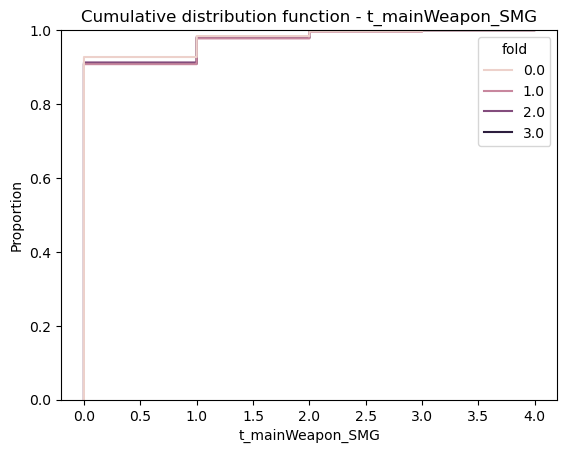

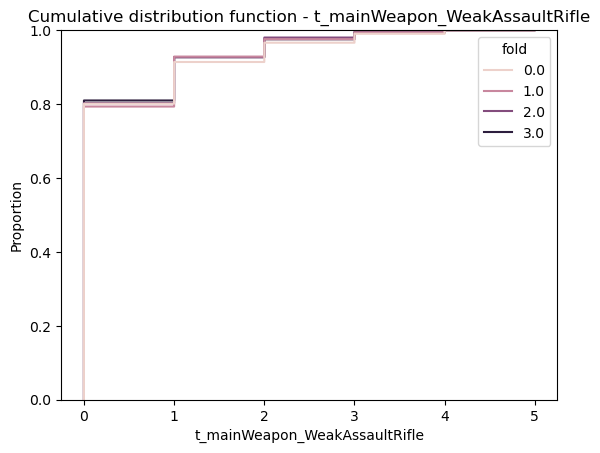

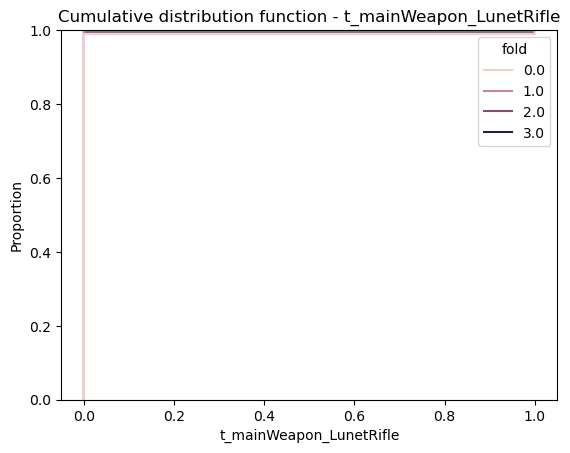

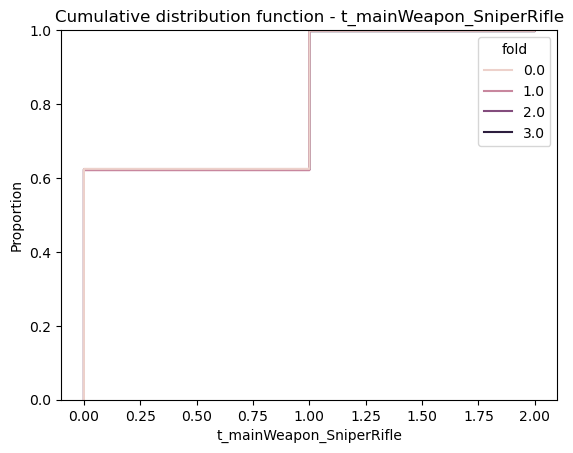

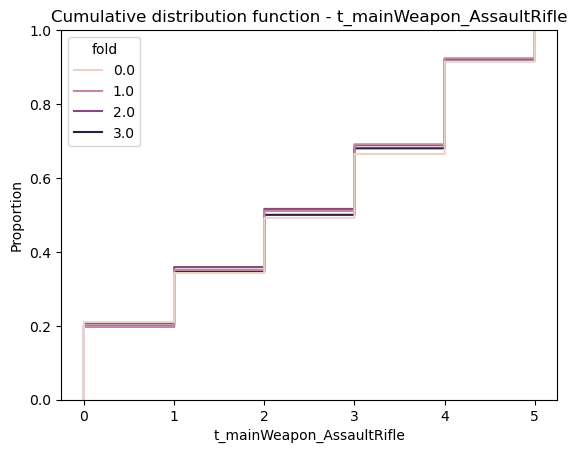

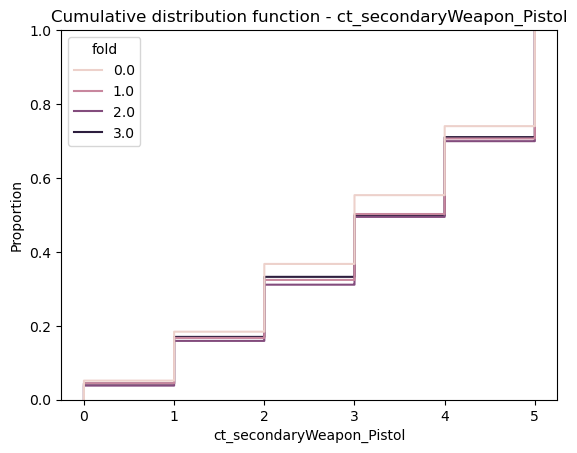

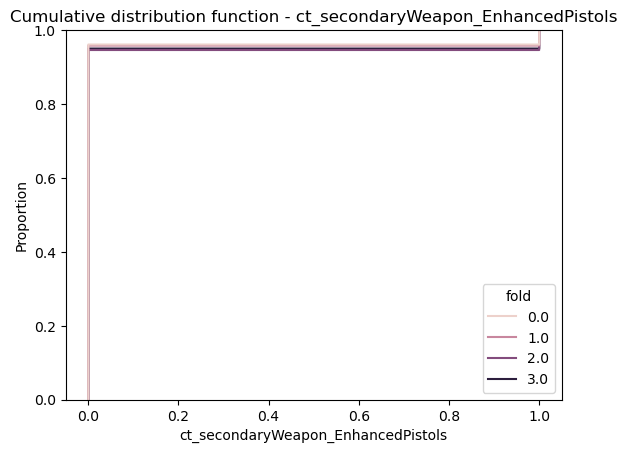

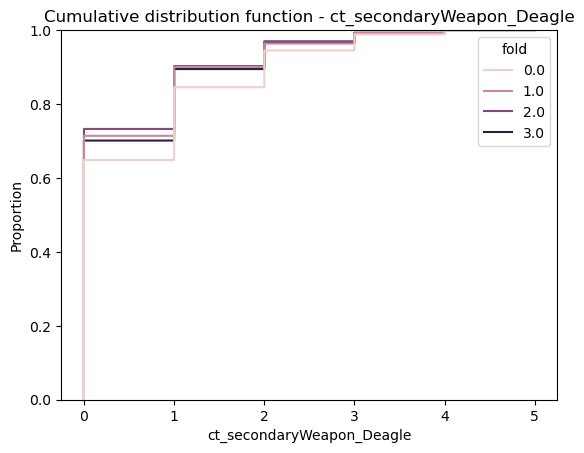

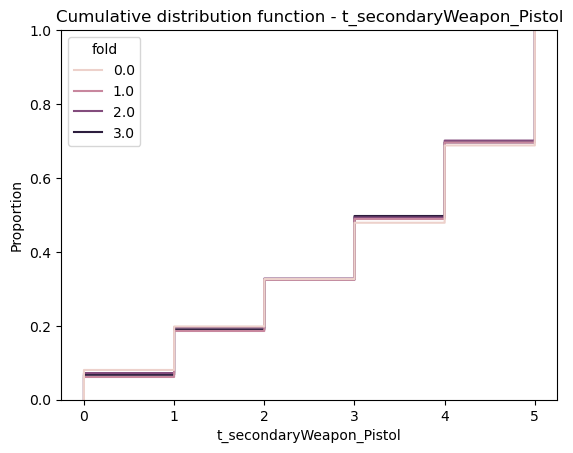

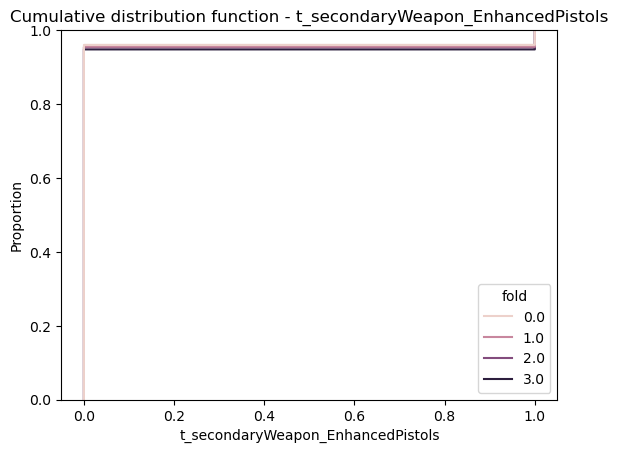

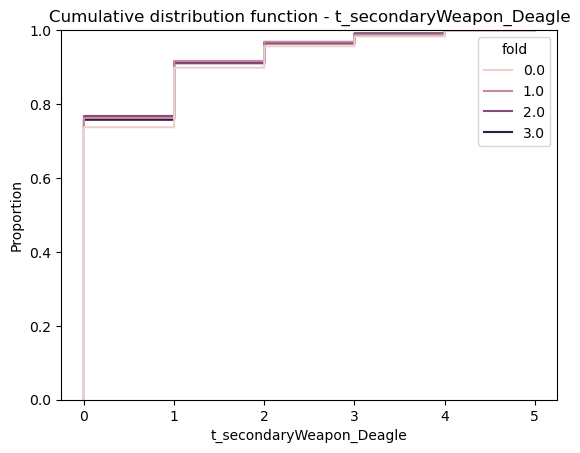

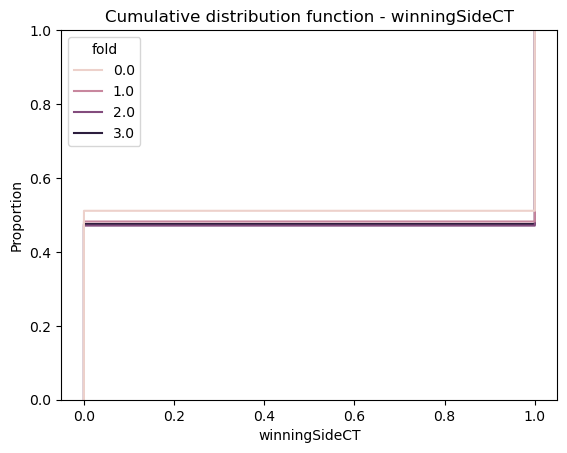

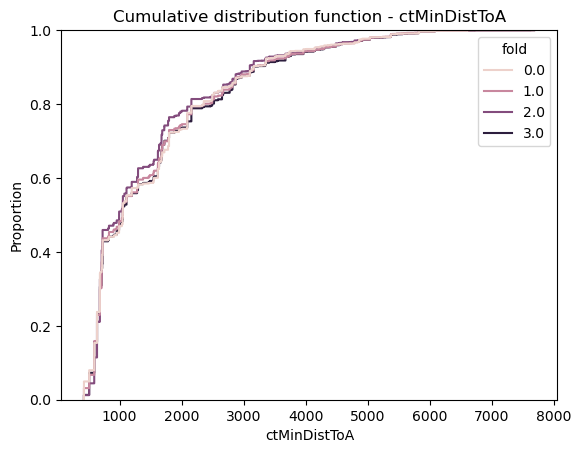

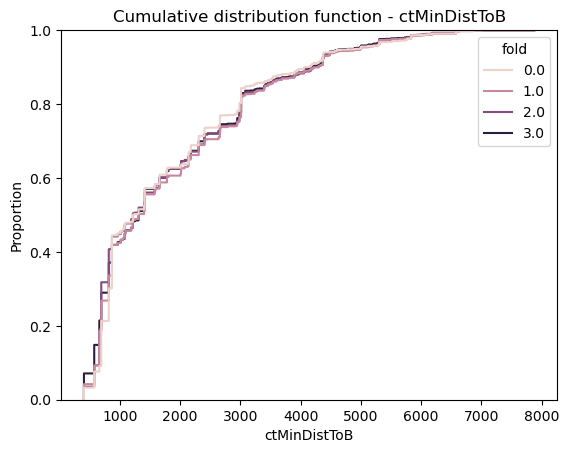

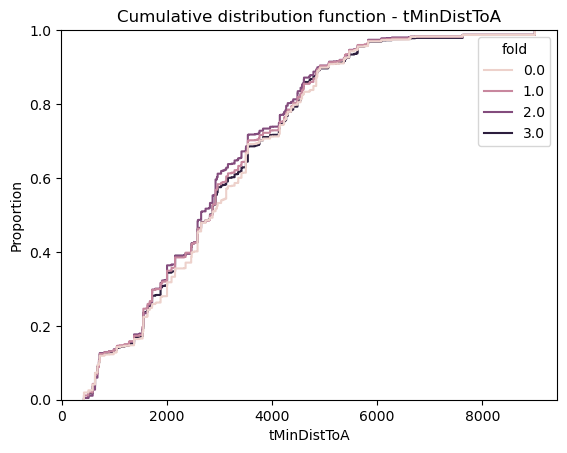

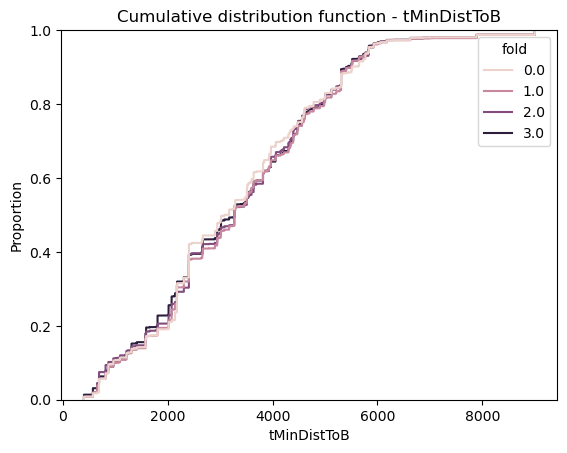

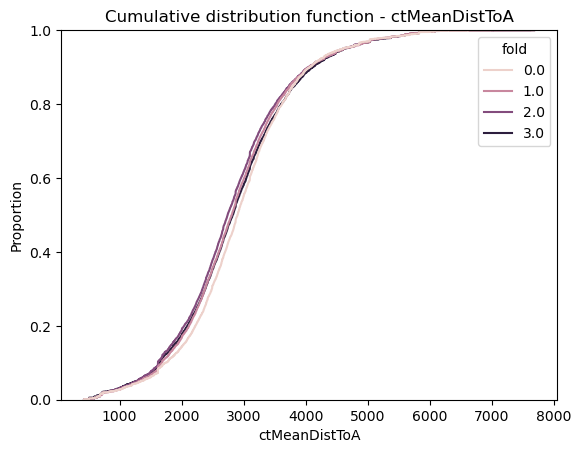

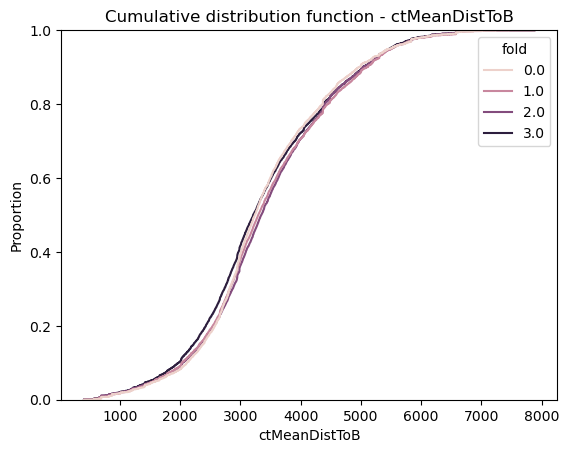

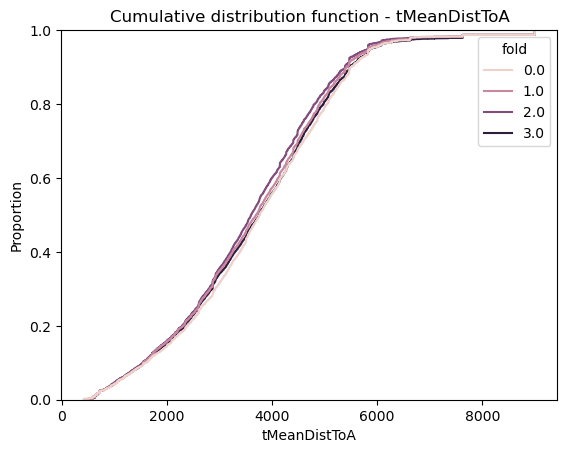

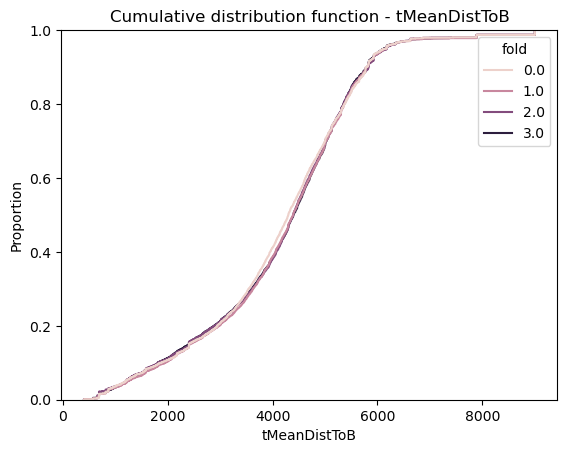

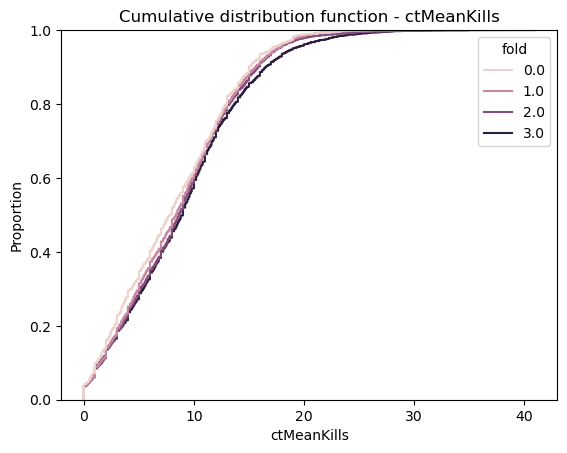

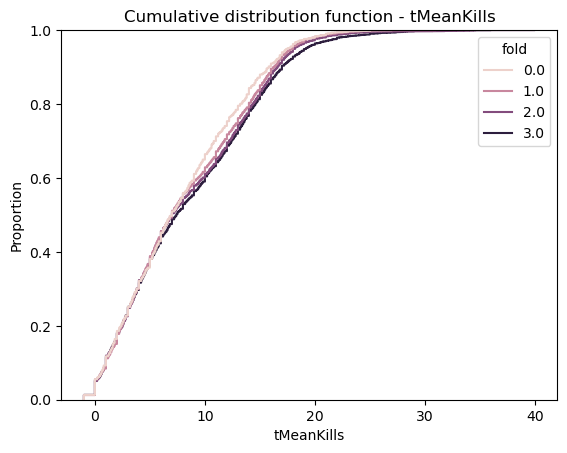

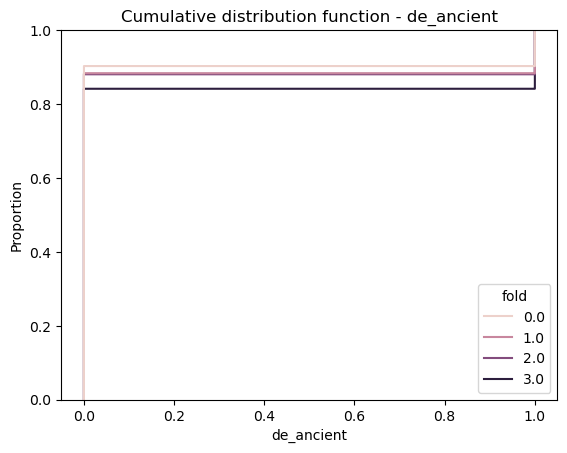

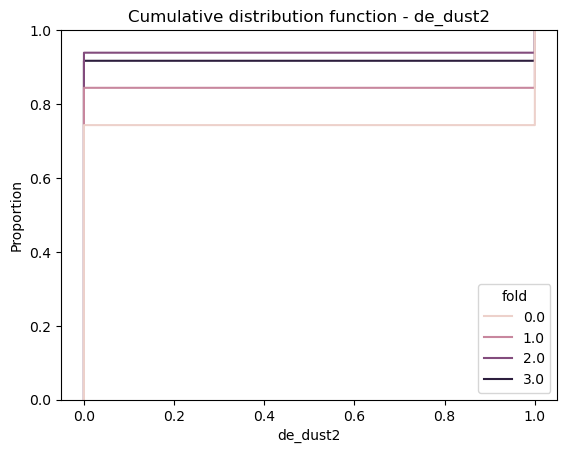

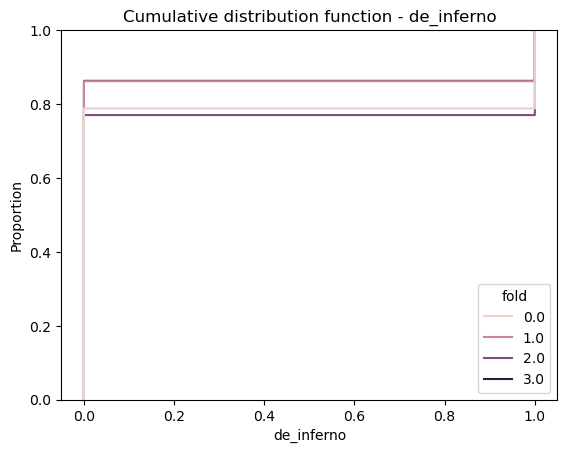

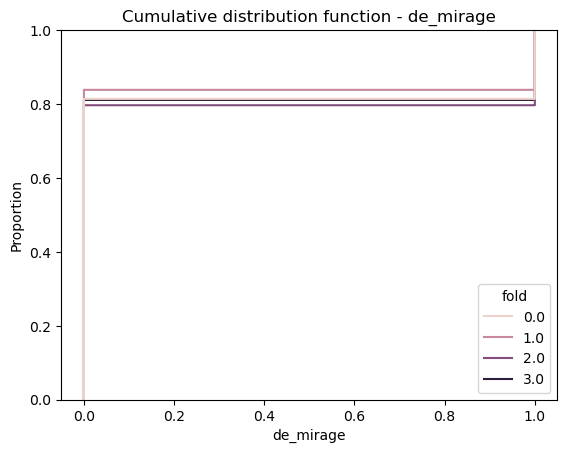

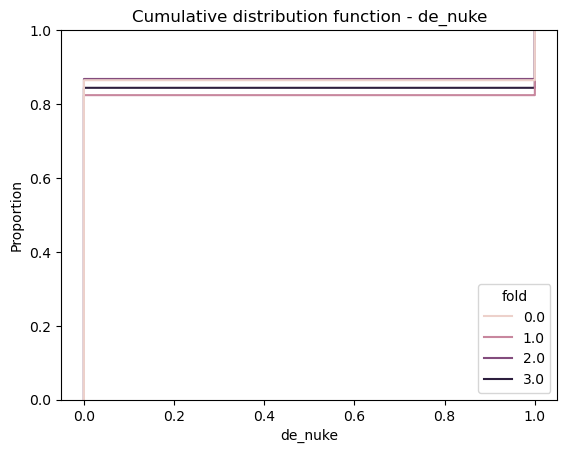

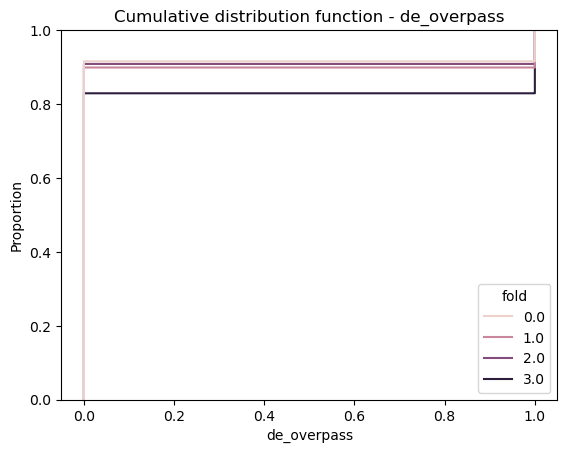

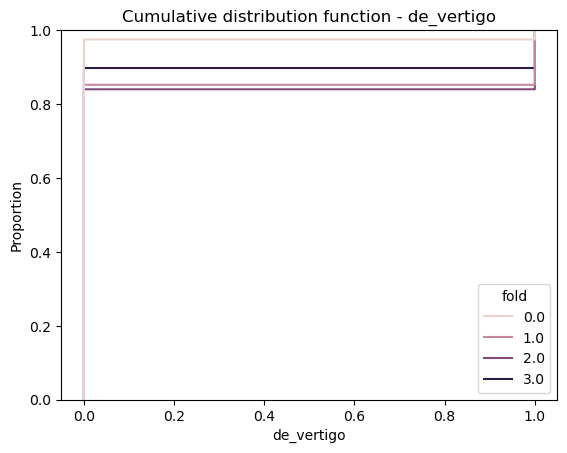

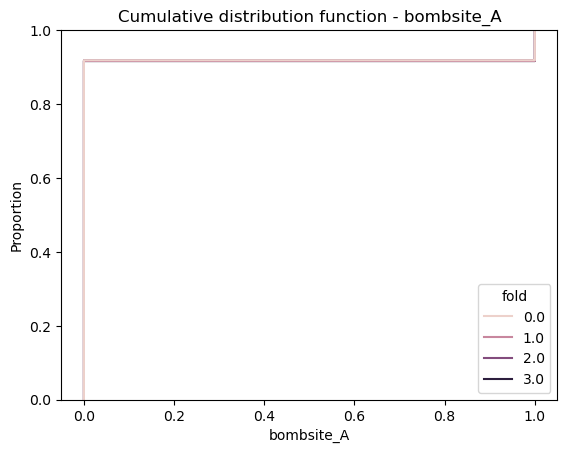

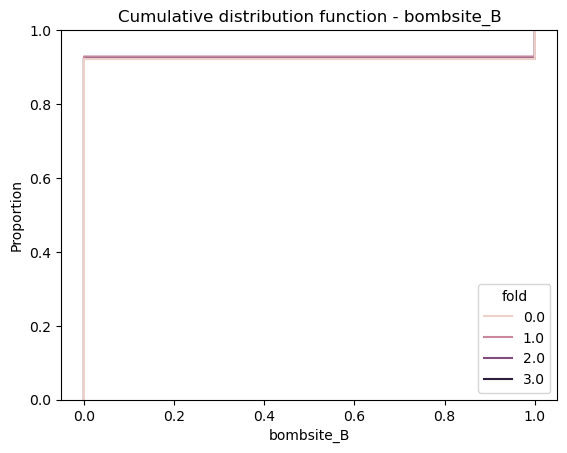

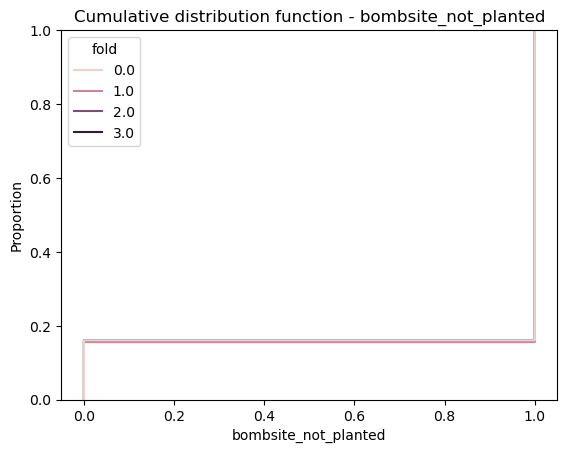

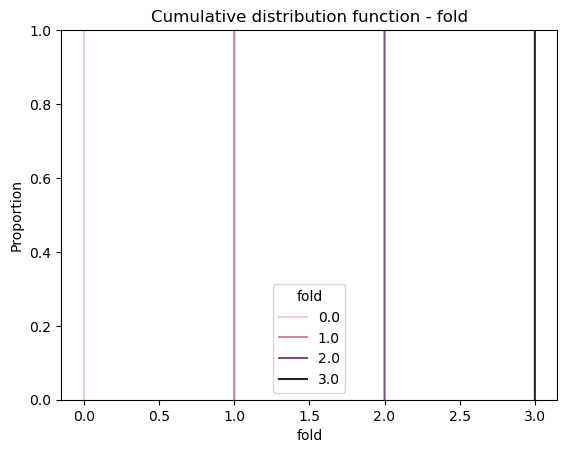

In [19]:
for col in df.select_dtypes('number'):
    sns.ecdfplot(x=col, data=df, hue='fold');
    plt.title(f"Cumulative distribution function - {col}")
    plt.show()

In [20]:
df.to_parquet("data/states_prepared_mod_fold.parquet")